# IMPORTS

In [5]:
import pandas as pd
import numpy as np
import sklearn as sk
import sklearn.model_selection as skms

# DATA IMPORTS

In [6]:
# Read the data
df = pd.read_csv('Datasets/finaldf.csv')
n = len(df)


df_test = pd.read_csv('Datasets/finaltest.csv')
# test can't have nans in order to be predicted
df_test['weight'] = df_test['weight'].fillna(df_test['weight'].mean())
df_test['late_order'] = True

m = len(df_test)
df_def = pd.concat([df, df_test])


# ANALISIS

In [7]:


def get_X_y(df, target):

    X = df.drop(['order_id', "logistic_hub", 'dist_origin_hub',
                "origin_port_coord", "logistic_hub_coord", "customer_coord", "dist_hub_customer", 
                'material_handling'], axis=1).dropna()
    if target:
        y = X['late_order']
        X = X.drop(['late_order'], axis=1)
    X['total_weight'] = X['weight']*X['units']
    X = X.drop(["units", "weight"], axis=1)

    return X if not target else (X, y)

X, y = get_X_y(df, True)
y = y.head(n)

X_enc = pd.get_dummies(X, columns= ["3pl", "origin_port", "customs_procedures", "customer"])
X_ori_enc = X_enc.head(n) 
X_test_enc = X_enc.tail(m)

X_train_enc, X_val_enc, y_train, y_val = skms.train_test_split(X_ori_enc, y, test_size=0.2)




In [8]:
from sklearn.tree import DecisionTreeClassifier
xval = [i for i in range(2, 30)]
rc = np.array([None for _ in range(2, 30)])

for i in range(2, 30):
    modelt = DecisionTreeClassifier(criterion="entropy", max_depth=i)
    modelt.fit(X_train_enc, y_train)
    y_pred = np.array(modelt.predict_proba(X_val_enc)) 
    rc[i-2] = sk.metrics.roc_auc_score(y_val, y_pred.T[1])

print(rc)

[0.6888758346980456 0.7145497138721013 0.7238230395904667
 0.7394006959390405 0.7567817989005494 0.7653266403050799
 0.7678822338907265 0.7714828269402769 0.7713065964209692
 0.7660593634959348 0.7588995936565978 0.7471293156749539
 0.7344780542290213 0.7227185002891158 0.706536074582333
 0.6959369422963151 0.68667408163593 0.6750383747862208 0.667875106023458
 0.659902682148906 0.6558380483440648 0.6503214088860202
 0.6453003956309885 0.6440725272069573 0.638728735623217
 0.6352006210282527 0.6339764418014289 0.6360555898383103]


[Text(0.5, 0.8333333333333334, 'total_weight <= 1061165.0\nentropy = 0.791\nsamples = 91326\nvalue = [69642, 21684]'),
 Text(0.25, 0.5, 'origin_port_Rotterdam <= 0.5\nentropy = 0.727\nsamples = 85461\nvalue = [68141, 17320]'),
 Text(0.125, 0.16666666666666666, 'entropy = 0.871\nsamples = 36551\nvalue = [25892, 10659]'),
 Text(0.375, 0.16666666666666666, 'entropy = 0.574\nsamples = 48910\nvalue = [42249, 6661]'),
 Text(0.75, 0.5, 'total_weight <= 1179454.0\nentropy = 0.821\nsamples = 5865\nvalue = [1501, 4364]'),
 Text(0.625, 0.16666666666666666, 'entropy = 0.985\nsamples = 2751\nvalue = [1180, 1571]'),
 Text(0.875, 0.16666666666666666, 'entropy = 0.479\nsamples = 3114\nvalue = [321, 2793]')]

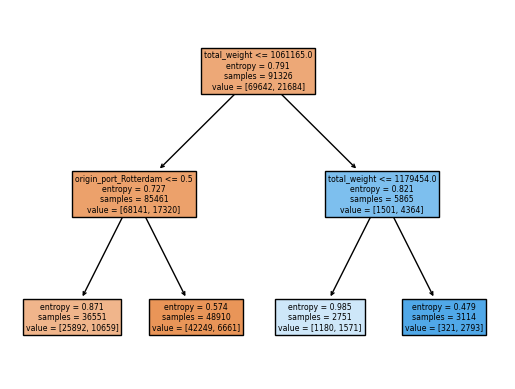

In [9]:
from sklearn.tree import plot_tree
dummodel = DecisionTreeClassifier(criterion="entropy", max_depth=2)
dummodel.fit(X_train_enc, y_train)
plot_tree(dummodel, filled=True, feature_names=X_train_enc.columns)

In [10]:
defmodel = DecisionTreeClassifier(criterion="entropy", max_depth=8)
defmodel.fit(X_train_enc, y_train)
y_pred = defmodel.predict_proba(X_val_enc)

scr = sk.metrics.roc_auc_score(y_val, y_pred.T[1])
print(scr)

0.7678822338907265


In [11]:
y_def = defmodel.predict_proba(X_test_enc)

print(y_def.T[1])


[0.1544731  0.25063594 0.08173717 ... 0.08173717 0.1544731  0.10894142]


In [59]:
submission = pd.DataFrame({"order_id": df_test.order_id, "late_order": y_def.T[1]})
submission.to_csv("pred_DTC.csv", index=False)